# Install and Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)
warnings.filterwarnings('ignore')
%matplotlib inline

# Load data

In [2]:
df = pd.read_csv('../loan-approval/dataset/data.csv', encoding= 'utf-8')
df.shape

(614, 13)

# Descriptive Analysis

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df['Credit_History'] = df['Credit_History'].astype('object')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    object 
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 62.5+ KB


## Deleting ID column

In [5]:
df['Loan_ID'].value_counts().sort_values(ascending=False)

LP001002    1
LP001014    1
LP001038    1
LP001036    1
LP001005    1
           ..
LP002974    1
LP002978    1
LP002979    1
LP002983    1
LP002990    1
Name: Loan_ID, Length: 614, dtype: int64

In [6]:
df.drop('Loan_ID', axis= 1, inplace= True)

ID of Loan is a unecessary feature to train the predictive model.

## NaN analysis

In [7]:
def highlight_nans(val):
    return 'background-color: lightcoral' if val != 0 else ''

In [8]:
df.isnull().sum().to_frame().rename(columns= {0:'NaN values'}).style.applymap(highlight_nans)

,NaN values
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14
Credit_History,50


### Numerical features

In [9]:
df[['LoanAmount','Loan_Amount_Term']].describe().T

,count,mean,std,min,25%,50%,75%,max
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.0,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.0,480.0


In [10]:
for column in ["LoanAmount", "Loan_Amount_Term"]:
    numeric_indexs_nan = random.choice(df[df[column].isnull()].index)

    start_index = max(numeric_indexs_nan - 2, 0)
    end_index = min(numeric_indexs_nan + 2, len(df[column]) - 1)
    
    print(f'Values of column "{column}" before filling NaNs with the mean:')
    print(df[column].iloc[start_index:end_index + 1])
    
    # Filling NaN values with the mean of column
    mean_value = round(df[column].mean(), 0)
    df[column].fillna(mean_value, inplace=True)
    print(f'\n*** Mean of column "{column}" is: {mean_value} ***')
    
    print(f'\nValues of column "{column}" after filling NaNs with the mean:')
    print(df[column].iloc[start_index:end_index + 1])
    print('--------------------------------------------------------\n')

Values of column "LoanAmount" before filling NaNs with the mean:
435      NaN
436     50.0
437      NaN
438    187.0
439    138.0
Name: LoanAmount, dtype: float64

*** Mean of column "LoanAmount" is: 146.0 ***

Values of column "LoanAmount" after filling NaNs with the mean:
435    146.0
436     50.0
437    146.0
438    187.0
439    138.0
Name: LoanAmount, dtype: float64
--------------------------------------------------------

Values of column "Loan_Amount_Term" before filling NaNs with the mean:
365    360.0
366    480.0
367      NaN
368    360.0
369    360.0
Name: Loan_Amount_Term, dtype: float64

*** Mean of column "Loan_Amount_Term" is: 342.0 ***

Values of column "Loan_Amount_Term" after filling NaNs with the mean:
365    360.0
366    480.0
367    342.0
368    360.0
369    360.0
Name: Loan_Amount_Term, dtype: float64
--------------------------------------------------------



### Categorical features

In [11]:
categorical_columns_nan = df.columns[df.isnull().any() & ~df.columns.isin(['LoanAmount','Loan_Amount_Term'])]

In [12]:
df[categorical_columns_nan].describe(include='object').T

,count,unique,top,freq
Gender,601,2,Male,489
Married,611,2,Yes,398
Dependents,599,4,0,345
Self_Employed,582,2,No,500
Credit_History,564.0,2.0,1.0,475.0


Number of rows in the dataframe with categorical null values: 103


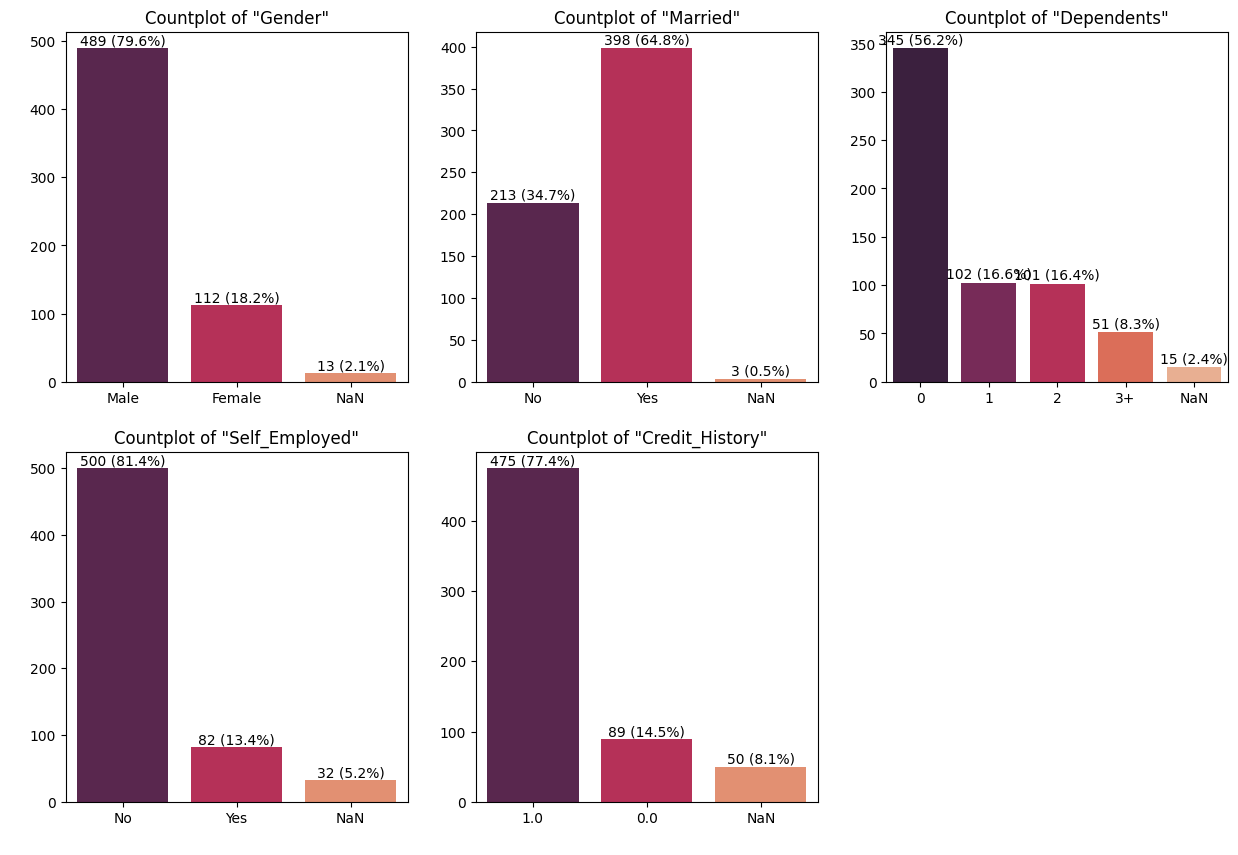

In [13]:
print('Number of rows in the dataframe with categorical null values:', df[df.isnull().any(axis=1)].shape[0])

df_categorical_columns_nan = df[categorical_columns_nan].copy()
df_categorical_columns_nan = df_categorical_columns_nan.fillna("NaN")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, column in enumerate(categorical_columns_nan):
    row = i // 3 
    col = i % 3
    
    sns.countplot(x=column, data=df_categorical_columns_nan, palette="rocket", ax=axes[row, col])

    total_entries = df_categorical_columns_nan[column].count()
    for p in axes[row, col].patches:
        height = p.get_height()
        axes[row, col].text(p.get_x() + p.get_width() / 2., height + 5, f'{int(height)} ({height / total_entries:.1%})', ha='center')
    
    axes[row, col].set_title(f'Countplot of "{column}"')
    axes[row, col].set_xlabel(' ')
    axes[row, col].set_ylabel(' ')


fig.delaxes(axes.flatten()[len(categorical_columns_nan)])

plt.show()

Since the missing values do not have a strong representation in the columns, they will be deleted. If they were representative, the following methods could be applied:
- Adding a weight variable
- Creating a new category
- Using a machine learning model for predicting the NaN category.

In [14]:
df = df.dropna()

In [15]:
print(df.shape)
df.isnull().sum().to_frame().rename(columns= {0:'NaN values'}).style.applymap(highlight_nans)

(511, 12)


,NaN values
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0
Credit_History,0


## Duplicated values

In [16]:
print('Total of duplicated values:', df[df.duplicated()].shape[0])

Total of duplicated values: 0


## Data Distribution

### Numerical features

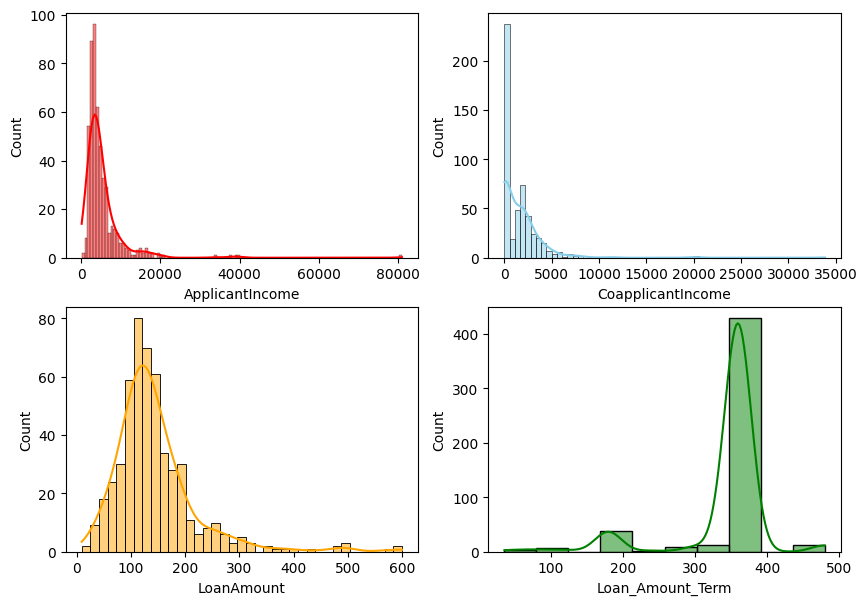

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='red')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange')
sns.histplot(data=df, x="Loan_Amount_Term", kde=True, ax=axs[1, 1], color='green');

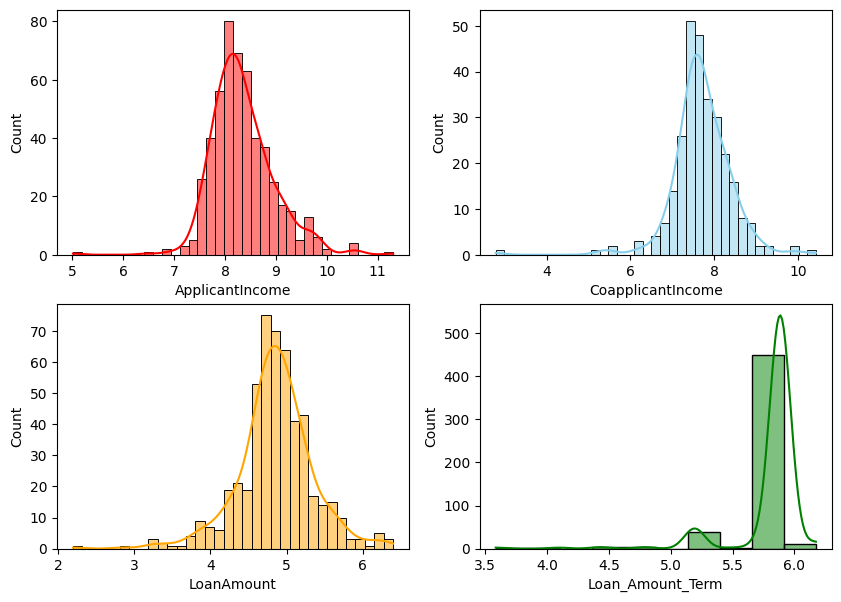

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

sns.histplot(data=df, x=np.log(df['ApplicantIncome']), kde=True, ax=axs[0, 0], color='red')
sns.histplot(data=df, x=np.log(df["CoapplicantIncome"]), kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x=np.log(df["LoanAmount"]), kde=True, ax=axs[1, 0], color='orange')
sns.histplot(data=df, x=np.log(df["Loan_Amount_Term"]), kde=True, ax=axs[1, 1], color='green');

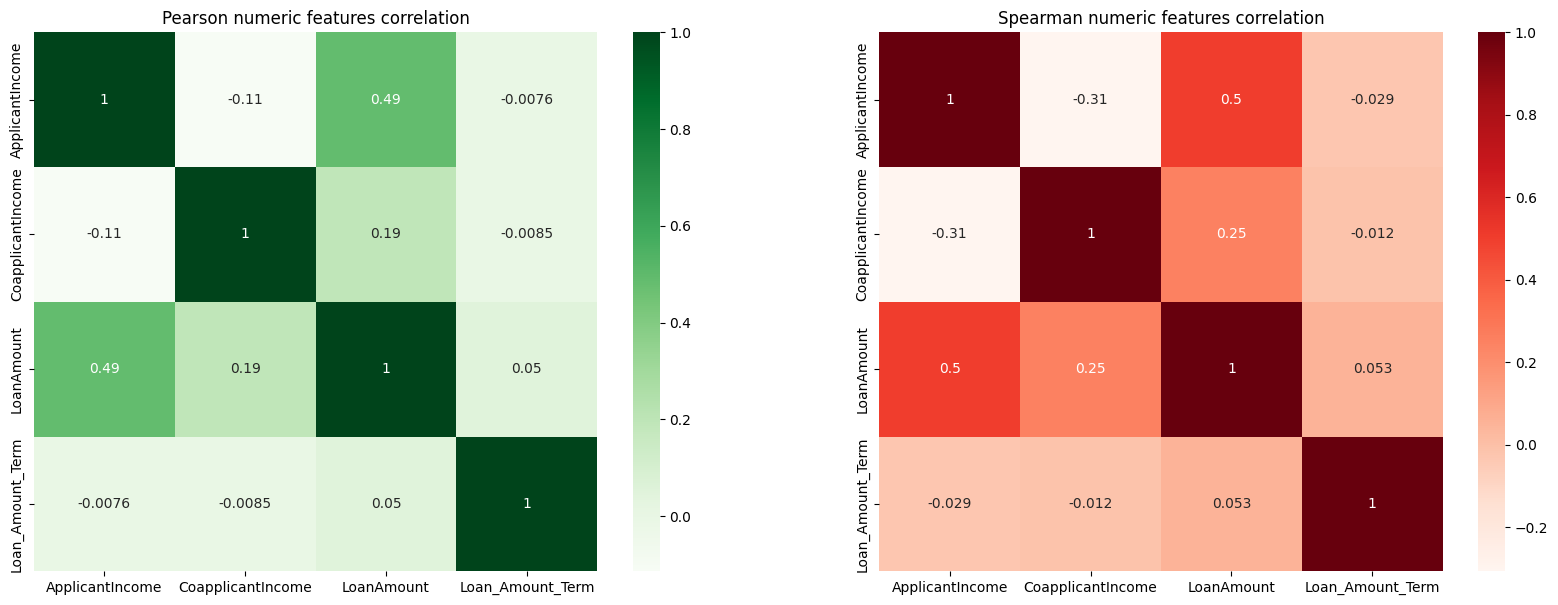

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

sns.heatmap(df.corr(), annot=True, cmap='Greens', ax=axs[0])
axs[0].set_title('Pearson numeric features correlation')

sns.heatmap(df.corr(method='spearman'), annot=True, cmap='Reds', ax=axs[1])
axs[1].set_title('Spearman numeric features correlation')

plt.show()

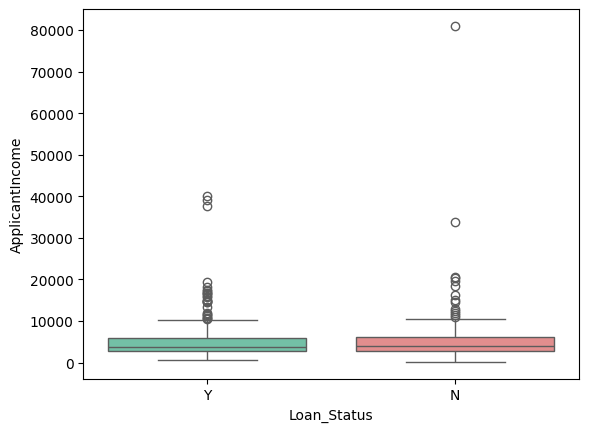

In [20]:
sns.boxplot(x="Loan_Status", y="ApplicantIncome", data=df, palette=({'Y':'mediumaquamarine','N':'lightcoral'}));

### Categorical features

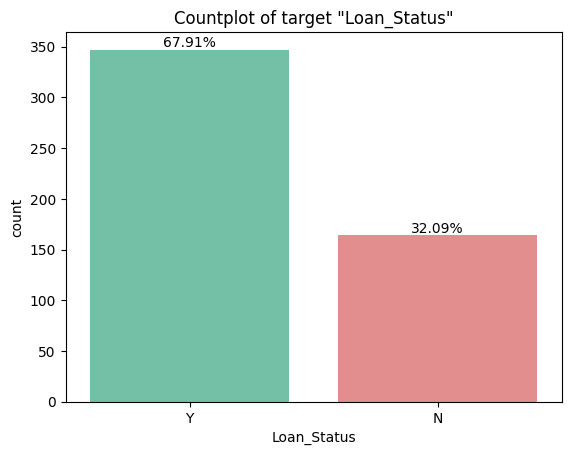

In [21]:
ax = sns.countplot(x='Loan_Status', data=df, palette=({'Y':'mediumaquamarine','N':'lightcoral'}))

total = len(df['Loan_Status'])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:.2f}%'.format((height / total) * 100), ha="center")

plt.title('Countplot of target "Loan_Status"')
plt.show()

Due to the target's imbalance, I will balance it later using the SMOTE method.

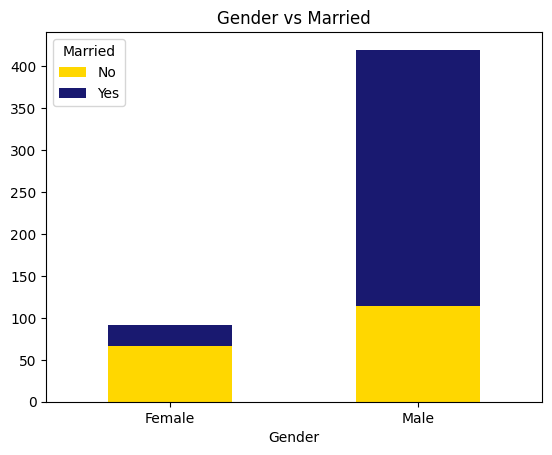

In [22]:
pd.crosstab(df['Gender'], df['Married']).plot(kind='bar', stacked=True, color=['gold','midnightblue'])
plt.title('Gender vs Married')
plt.xticks(rotation=0)
plt.show()

Most male applicants are already married compared to female applicants. Additionally, the number of unmarried male applicants is higher compare to unmarried female applicants.

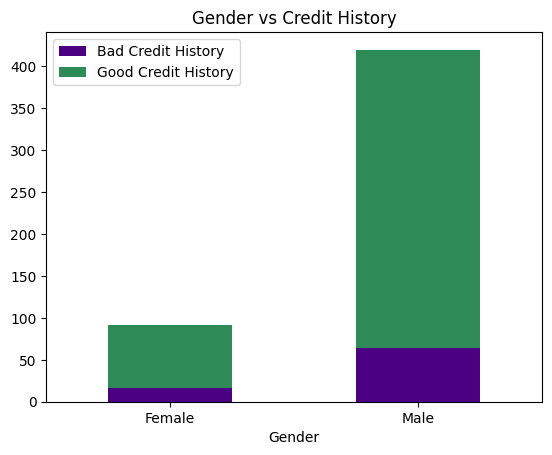

In [23]:
pd.crosstab(df['Gender'], df['Credit_History']).plot(kind='bar', stacked=True, color=['indigo','seagreen'])
plt.title('Gender vs Credit History')
plt.legend(["Bad Credit History", "Good Credit History"])
plt.xticks(rotation=0)
plt.show()

The number of applicants with a good credit history is higher for both men and women.

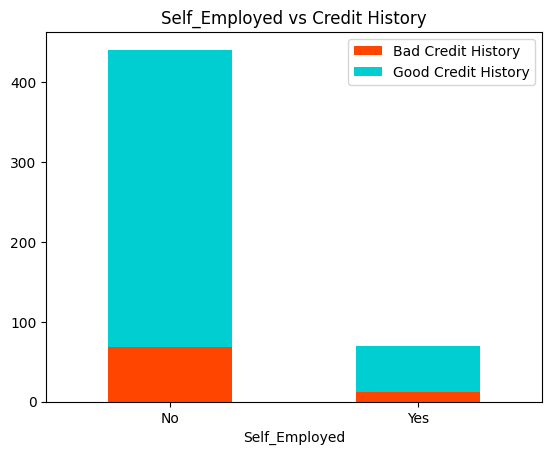

In [24]:
pd.crosstab(df['Self_Employed'], df['Credit_History']).plot(kind='bar', stacked=True, color=['orangered','darkturquoise'])
plt.title('Self_Employed vs Credit History')
plt.legend(["Bad Credit History", "Good Credit History"])
plt.xticks(rotation=0)
plt.show()

Most not self employed applicants have good credit compared to self employed applicants.

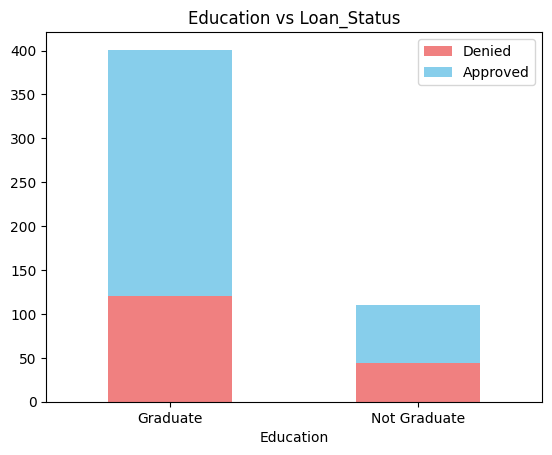

In [25]:
pd.crosstab(df['Education'], df['Loan_Status']).plot(kind='bar', stacked=True, color=['lightcoral','skyblue'])
plt.title('Education vs Loan_Status')
plt.legend(["Denied", "Approved"])
plt.xticks(rotation=0)
plt.show()

Most graduated applicants have more Loan approvals compared to non graduated applicants.

# Feature Engineering

## Dummies

### Nominal features

In [26]:
df = pd.get_dummies(data=df, columns=['Gender','Married','Education','Self_Employed','Credit_History','Loan_Status','Property_Area'], drop_first=True)

# Rename columns name
rename_dummies_columns = {'Gender_Male': 'Gender', 'Married_Yes': 'Married', 
                            'Education_Not Graduate': 'Education', 'Self_Employed_Yes': 'Self_Employed',
                            'Credit_History_1.0': 'Credit_History', 'Loan_Status_Y': 'Loan_Status'}
       
df.rename(columns=rename_dummies_columns, inplace=True)

### Ordinal features

In [27]:
label_encoder = LabelEncoder()

df['Dependents'] = label_encoder.fit_transform(df['Dependents'])

## Deleting features with no importance after testing some models

In [28]:
df.drop(columns=['Self_Employed','Education','CoapplicantIncome','Dependents'], inplace= True)

This treatment was performed after testing different predictive models and positioned at this point in the code because the features 'Self_Employed', 'Education', 'CoapplicantIncome' and 'Dependents' did not show importance in the training below. Therefore, their exclusion does not affect the evaluation metrics.

## Train test split

In [29]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=42)

## Data balancing - SMOTE

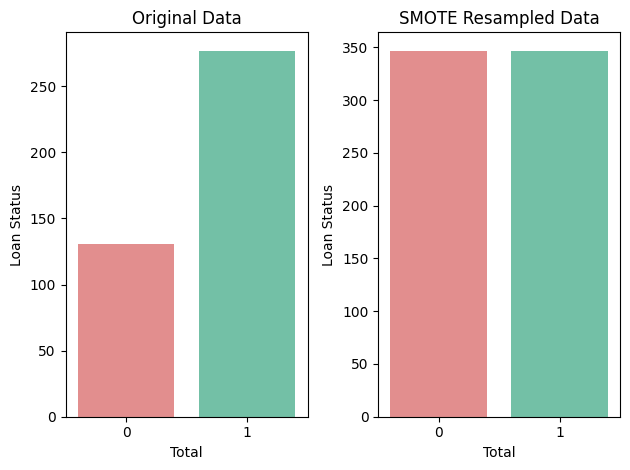

In [31]:
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, data=X_train, palette=({'1':'mediumaquamarine','0':'lightcoral'}))
plt.ylabel('Loan Status')
plt.xlabel('Total')
plt.title('Original Data')


X_train, y_train = SMOTE().fit_resample(X, y)


plt.subplot(1, 2, 2)
sns.countplot(x=y_train, data=X_train, palette=({'1':'mediumaquamarine','0':'lightcoral'}))
plt.ylabel('Loan Status')
plt.xlabel('Total')
plt.title('SMOTE Resampled Data')

plt.tight_layout()
plt.show()

## Data Scaling

In [32]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [33]:
pd.DataFrame(X_train_scaled, columns=X.columns).head()

,ApplicantIncome,LoanAmount,Loan_Amount_Term,Gender,Married,Credit_History,Property_Area_Semiurban,Property_Area_Urban
0,0.086768,-0.027118,0.283623,0.569585,-1.152761,0.667708,-0.6632,1.652629
1,-0.146268,-0.249746,0.283623,0.569585,0.867482,0.667708,-0.6632,-0.605096
2,-0.437654,-1.016576,0.283623,0.569585,0.867482,0.667708,-0.6632,1.652629
3,-0.514413,-0.348692,0.283623,0.569585,0.867482,0.667708,-0.6632,1.652629
4,0.114562,-0.088959,0.283623,0.569585,-1.152761,0.667708,-0.6632,1.652629


# Predictive Model

## Testing Models

### Logistic Regression

In [34]:
lr = LogisticRegression(class_weight='balanced')

In [35]:
lr.fit(X_train_scaled, y_train)

y_train_pred_lr = lr.predict(X_train_scaled)
y_pred_lr = lr.predict(X_test_scaled)

In [36]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.61      0.75        33
           1       0.84      1.00      0.92        70

    accuracy                           0.87       103
   macro avg       0.92      0.80      0.83       103
weighted avg       0.89      0.87      0.86       103



In [37]:
acc = accuracy_score(y_train, y_train_pred_lr)
precision = precision_score(y_train, y_train_pred_lr)
recall = recall_score(y_train, y_train_pred_lr)
print(f'[Training Logistic Regression] Accuracy: {acc*100:.2f}%')
print(f'[Training Logistic Regression] Precision: {precision*100:.2f}%')
print(f'[Training Logistic Regression] Recall: {recall*100:.2f}% \n')

acc_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
print(f'[Testing Logistic Regression] Accuracy: {acc_lr*100:.2f}%')
print(f'[Testing Logistic Regression] Precision: {precision_lr*100:.2f}%')
print(f'[Testing Logistic Regression] Recall: {recall_lr*100:.2f}%')

[Training Logistic Regression] Accuracy: 82.28%
[Training Logistic Regression] Precision: 77.32%
[Training Logistic Regression] Recall: 91.35% 

[Testing Logistic Regression] Accuracy: 87.38%
[Testing Logistic Regression] Precision: 84.34%
[Testing Logistic Regression] Recall: 100.00%


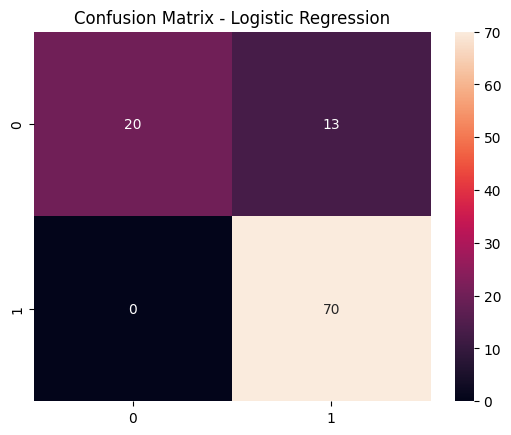

In [38]:
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True)
plt.title('Confusion Matrix - Logistic Regression');

### Support Vector Machine (SVM)

In [39]:
svc = svm.SVC(kernel='rbf')

In [40]:
svc.fit(X_train_scaled, y_train)

y_train_pred_svc = svc.predict(X_train_scaled)
y_pred_svc = svc.predict(X_test_scaled)

In [41]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        33
           1       0.86      1.00      0.93        70

    accuracy                           0.89       103
   macro avg       0.93      0.83      0.86       103
weighted avg       0.91      0.89      0.89       103



In [42]:
acc = accuracy_score(y_train, y_train_pred_svc)
precision = precision_score(y_train, y_train_pred_svc)
recall = recall_score(y_train, y_train_pred_svc)
print(f'[Training Support Vector Machine (SVM)] Accuracy: {acc*100:.2f}%')
print(f'[Training Support Vector Machine (SVM)] Precision: {precision*100:.2f}%')
print(f'[Training Support Vector Machine (SVM)] Recall: {recall*100:.2f}% \n')

acc_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
print(f'[Testing Support Vector Machine (SVM)] Accuracy: {acc_svc*100:.2f}%')
print(f'[Testing Support Vector Machine (SVM)] Precision: {precision_svc*100:.2f}%')
print(f'[Testing Support Vector Machine (SVM)] Recall: {recall_svc*100:.2f}%')

[Training Support Vector Machine (SVM)] Accuracy: 85.45%
[Training Support Vector Machine (SVM)] Precision: 80.00%
[Training Support Vector Machine (SVM)] Recall: 94.52% 

[Testing Support Vector Machine (SVM)] Accuracy: 89.32%
[Testing Support Vector Machine (SVM)] Precision: 86.42%
[Testing Support Vector Machine (SVM)] Recall: 100.00%


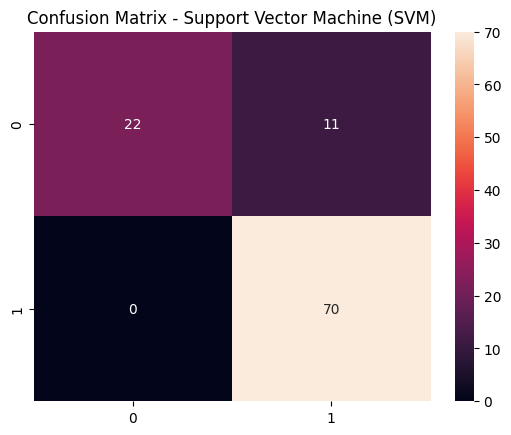

In [43]:
sns.heatmap(confusion_matrix(y_test, y_pred_svc), annot=True)
plt.title('Confusion Matrix - Support Vector Machine (SVM)');

### K-Nearest Neighbors (KNN)

In [44]:
print(f'Number of nearest neighbors: {round(math.sqrt(len(y_test)),2)}. \nTo avoid a tie in the voting among the neighbors, the number will be rounded to 9')

Number of nearest neighbors: 10.15. 
To avoid a tie in the voting among the neighbors, the number will be rounded to 9


In [45]:
knn = KNeighborsClassifier(n_neighbors=9, metric='euclidean')

In [46]:
knn.fit(X_train_scaled, y_train)

y_train_pred_knn = knn.predict(X_train_scaled)
y_pred_knn = knn.predict(X_test_scaled)

In [47]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.91      0.64      0.75        33
           1       0.85      0.97      0.91        70

    accuracy                           0.86       103
   macro avg       0.88      0.80      0.83       103
weighted avg       0.87      0.86      0.86       103



In [48]:
acc = accuracy_score(y_train, y_train_pred_knn)
precision = precision_score(y_train, y_train_pred_knn)
recall = recall_score(y_train, y_train_pred_knn)
print(f'[Training K-Nearest Neighbors (KNN)] Accuracy: {acc*100:.2f}%')
print(f'[Training K-Nearest Neighbors (KNN)] Precision: {precision*100:.2f}%')
print(f'[Training K-Nearest Neighbors (KNN)] Recall: {recall*100:.2f}% \n')

acc_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
print(f'[Testing K-Nearest Neighbors (KNN)] Accuracy: {acc_knn*100:.2f}%')
print(f'[Testing K-Nearest Neighbors (KNN)] Precision: {precision_knn*100:.2f}%')
print(f'[Testing K-Nearest Neighbors (KNN)] Recall: {recall_knn*100:.2f}%')

[Training K-Nearest Neighbors (KNN)] Accuracy: 84.87%
[Training K-Nearest Neighbors (KNN)] Precision: 79.80%
[Training K-Nearest Neighbors (KNN)] Recall: 93.37% 

[Testing K-Nearest Neighbors (KNN)] Accuracy: 86.41%
[Testing K-Nearest Neighbors (KNN)] Precision: 85.00%
[Testing K-Nearest Neighbors (KNN)] Recall: 97.14%


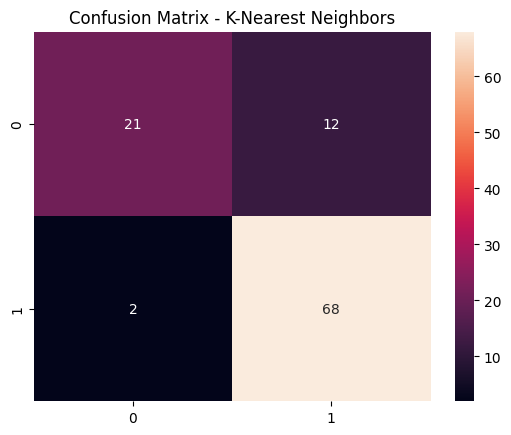

In [49]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True)
plt.title('Confusion Matrix - K-Nearest Neighbors');

### Decision Tree

In [50]:
dtree = DecisionTreeClassifier(criterion = 'entropy',
                                max_depth=6,
                                min_samples_split=50,
                                min_samples_leaf=5,)

In [51]:
dtree.fit(X_train_scaled, y_train)

y_train_pred_dtree = dtree.predict(X_train)
y_pred_dtree = dtree.predict(X_test_scaled)

In [52]:
print(classification_report(y_test, y_pred_dtree))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        33
           1       0.86      1.00      0.93        70

    accuracy                           0.89       103
   macro avg       0.93      0.83      0.86       103
weighted avg       0.91      0.89      0.89       103



In [53]:
acc = accuracy_score(y_train, y_train_pred_dtree)
precision = precision_score(y_train, y_train_pred_dtree)
recall = recall_score(y_train, y_train_pred_dtree)
print(f'[Training Decision Tree] Accuracy: {acc*100:.2f}%')
print(f'[Training Decision Tree] Precision: {precision*100:.2f}%')
print(f'[Training Decision Tree] Recall: {recall*100:.2f}% \n')

acc_dtree = accuracy_score(y_test, y_pred_dtree)
precision_dtree = precision_score(y_test, y_pred_dtree)
recall_dtree = recall_score(y_test, y_pred_dtree)
print(f'[Testing Decision Tree] Accuracy: {acc_dtree*100:.2f}%')
print(f'[Testing Decision Tree] Precision: {precision_dtree*100:.2f}%')
print(f'[Testing Decision Tree] Recall: {recall_dtree*100:.2f}%')

[Training Decision Tree] Accuracy: 63.54%
[Training Decision Tree] Precision: 72.17%
[Training Decision Tree] Recall: 44.09% 

[Testing Decision Tree] Accuracy: 89.32%
[Testing Decision Tree] Precision: 86.42%
[Testing Decision Tree] Recall: 100.00%


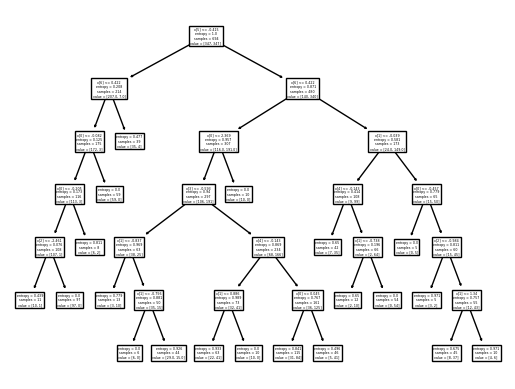

In [54]:
plot_tree(dtree);

## Comparing Models

In [55]:
df_model_comparison = pd.DataFrame({'Model': ['Logistic Regression', 'Support Vector Machine (SVM)', 'K-Nearest Neighbors (KNN)', 'Decision Tree'], 
                        'Accuracy %': [acc_lr, acc_svc, acc_knn, acc_dtree],
                        'Precision %': [precision_lr, precision_svc, precision_knn, precision_dtree],
                        'Recall %': [recall_lr, recall_svc, recall_knn, recall_dtree]})

df_model_comparison['Accuracy %'] = round(df_model_comparison['Accuracy %'] * 100,2)
df_model_comparison['Precision %'] = round(df_model_comparison['Precision %'] * 100,2)
df_model_comparison['Recall %'] = round(df_model_comparison['Recall %'] * 100,2)

df_model_comparison.sort_values(by='Accuracy %', ascending=False, inplace= True)
df_model_comparison

,Model,Accuracy %,Precision %,Recall %
1,Support Vector Machine (SVM),89.32,86.42,100.00
3,Decision Tree,89.32,86.42,100.00
0,Logistic Regression,87.38,84.34,100.00
2,K-Nearest Neighbors (KNN),86.41,85.00,97.14


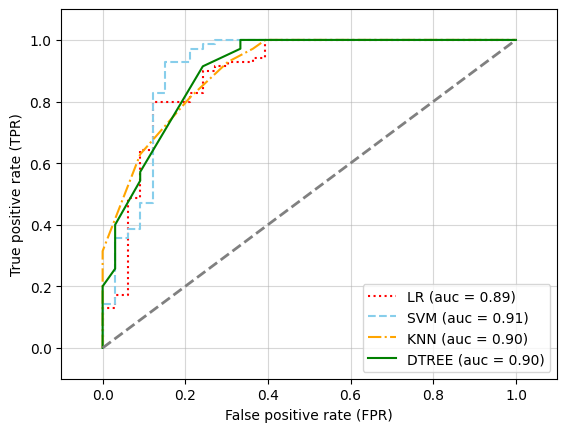

In [56]:
all_clf = [lr, svc, knn, dtree]
clf_labels = ["LR", "SVM", "KNN", "DTREE"]
colors = ["red", "skyblue", "orange", "green"]
linestyles = [":", "--", "-.", "-"]

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    if hasattr(clf, "decision_function"):
        y_score = clf.fit(X_train_scaled, y_train).decision_function(X_test_scaled)
    else:
        y_score = clf.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

In [57]:
df_model_comparison[df_model_comparison['Model'].eq('Support Vector Machine (SVM)')]

,Model,Accuracy %,Precision %,Recall %
1,Support Vector Machine (SVM),89.32,86.42,100.0


## Tunning

In [58]:
# defining parameter range
svm_tunned = svm.SVC(random_state=42)

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','rbf']}

grid = GridSearchCV(svm_tunned,param_grid, verbose=3)

In [59]:
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.698 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.727 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.813 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.856 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.848 total time=   0.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.669 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.763 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.799 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.820 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.790 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.698 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

In [60]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1, gamma=0.1, random_state=42)


In [61]:
best_svc = grid.best_estimator_

In [62]:
best_svc.fit(X_train_scaled, y_train)

y_train_pred_best_svc = best_svc.predict(X_train_scaled)
y_pred_best_svc = best_svc.predict(X_test_scaled)

In [63]:
acc = accuracy_score(y_train, y_train_pred_best_svc)
precision = precision_score(y_train, y_train_pred_best_svc)
recall = recall_score(y_train, y_train_pred_best_svc)
print(f'[Training Support Vector Machine (SVM) Tunned] Accuracy: {acc*100:.2f}%')
print(f'[Training Support Vector Machine (SVM) Tunned] Precision: {precision*100:.2f}%')
print(f'[Training Support Vector Machine (SVM) Tunned] Recall: {recall*100:.2f}% \n')

acc_best_svc = accuracy_score(y_test, y_pred_best_svc)
precision_best_svc = precision_score(y_test, y_pred_best_svc)
recall_best_svc = recall_score(y_test, y_pred_best_svc)
print(f'[Testing Support Vector Machine (SVM) Tunned] Accuracy: {acc_best_svc*100:.2f}%')
print(f'[Testing Support Vector Machine (SVM) Tunned] Precision: {precision_best_svc*100:.2f}%')
print(f'[Testing Support Vector Machine (SVM) Tunned] Recall: {recall_best_svc*100:.2f}%')

[Training Support Vector Machine (SVM) Tunned] Accuracy: 85.16%
[Training Support Vector Machine (SVM) Tunned] Precision: 79.61%
[Training Support Vector Machine (SVM) Tunned] Recall: 94.52% 

[Testing Support Vector Machine (SVM) Tunned] Accuracy: 89.32%
[Testing Support Vector Machine (SVM) Tunned] Precision: 86.42%
[Testing Support Vector Machine (SVM) Tunned] Recall: 100.00%


In [64]:
df_svc_comparison = pd.DataFrame({'Model': ['Support Vector Machine (SVM)', 'Tunned Support Vector Machine (SVM)'], 
                        'Accuracy %': [acc_svc, acc_best_svc],
                        'Precision %': [precision_svc, precision_best_svc],
                        'Recall %': [recall_svc, recall_best_svc]})

df_svc_comparison['Accuracy %'] = round(df_svc_comparison['Accuracy %'] * 100,2)
df_svc_comparison['Precision %'] = round(df_svc_comparison['Precision %'] * 100,2)
df_svc_comparison['Recall %'] = round(df_svc_comparison['Recall %'] * 100,2)

df_svc_comparison.sort_values(by='Accuracy %', ascending=False, inplace= True)
df_svc_comparison

,Model,Accuracy %,Precision %,Recall %
0,Support Vector Machine (SVM),89.32,86.42,100.0
1,Tunned Support Vector Machine (SVM),89.32,86.42,100.0


## Feature Importance

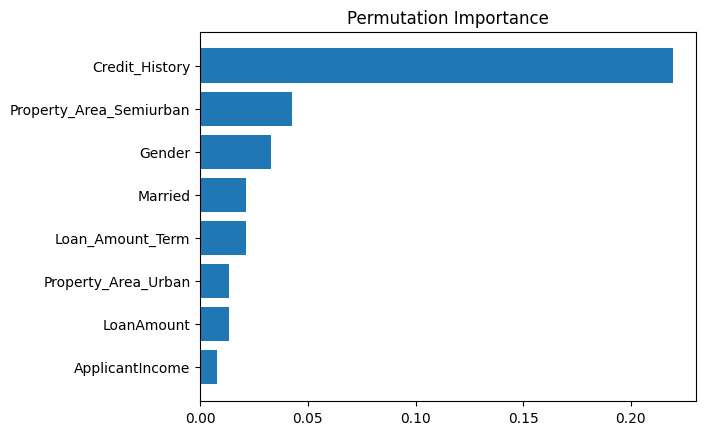

In [65]:
perm_importance = permutation_importance(svc, X_test_scaled, y_test)

features = X.columns.values

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Permutation Importance")
plt.show()